In [1]:
# importaing the required libraries

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from utils import (calculate_average_hourly_energy_consumption, train_model, get_pred, calculate_hierarchical_f1_score,
sample_submission_generator)


In [67]:
load_filepath_bldg = os.path.join(os.getcwd(),'data', 'train', '3.parquet') # path to a file in the train dataset
df_bldg = pd.read_parquet(load_filepath_bldg, engine='pyarrow')

# show the first 10 rows of the df_bldg dataframe
df_bldg#.head(10)

,timestamp,out.electricity.total.energy_consumption,in.state
bldg_id,,,
3,2018-01-01 00:15:00,7.570494,WA
3,2018-01-01 00:30:00,7.680802,WA
3,2018-01-01 00:45:00,9.186041,WA
3,2018-01-01 01:00:00,9.432656,WA
3,2018-01-01 01:15:00,9.327925,WA
...,...,...,...
3,2018-12-31 23:00:00,7.160821,WA
3,2018-12-31 23:15:00,7.091155,WA
3,2018-12-31 23:30:00,7.200812,WA


In [61]:
# aggregate df_bldg to daily energy consumption
df_bldg['timestamp'] = pd.to_datetime(df_bldg['timestamp'])

# Extract month and hour from 'timestamp'
df_bldg['month'] = df_bldg['timestamp'].dt.month
df_bldg['day'] = df_bldg['timestamp'].dt.day
df_bldg['hour'] = df_bldg['timestamp'].dt.hour

# create a column in df_bldg that states what day of the week it is based on the timestamp
# 0 is Monday and 6 is Sunday
df_bldg['day_of_week'] = df_bldg['timestamp'].dt.dayofweek

# make of list of timestamps of all the federal holidays in the US from 2018 to 2019
federal_holidays = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03', '2018-10-08',
                    '2018-11-12', '2018-11-22', '2018-12-25', '2019-01-01', '2019-01-21', '2019-02-18', '2019-05-27',
                    '2019-07-04', '2019-09-02', '2019-10-14', '2019-11-11', '2019-11-28', '2019-12-25']

# create a column in df_bldg that states if the timestamp is a federal holiday
df_bldg['federal_holiday'] = df_bldg['timestamp'].dt.date.astype(str).isin(federal_holidays)


In [63]:
df_bldg

,timestamp,out.electricity.total.energy_consumption,in.state,month,day,hour,day_of_week,federal_holiday
bldg_id,,,,,,,,
3,2018-01-01 00:15:00,7.570494,WA,1,1,0,0,True
3,2018-01-01 00:30:00,7.680802,WA,1,1,0,0,True
3,2018-01-01 00:45:00,9.186041,WA,1,1,0,0,True
3,2018-01-01 01:00:00,9.432656,WA,1,1,1,0,True
3,2018-01-01 01:15:00,9.327925,WA,1,1,1,0,True
...,...,...,...,...,...,...,...,...
3,2018-12-31 23:00:00,7.160821,WA,12,31,23,0,False
3,2018-12-31 23:15:00,7.091155,WA,12,31,23,0,False
3,2018-12-31 23:30:00,7.200812,WA,12,31,23,0,False


## Energy Consumption Holiday vs Non-Holiday

In [64]:
# sum the energy consumption based on day_of_week, month, and hour
# we can try hourly basis and do binary encoding of 0 vs 1 for holidays & non-holidays
df_bldg_daily = df_bldg.groupby(['day_of_week','federal_holiday']).agg({'out.electricity.total.energy_consumption': 'mean'}).reset_index()
df_bldg_daily

,day_of_week,federal_holiday,out.electricity.total.energy_consumption
0,0,False,11.774132
1,0,True,13.139883
2,1,False,11.798497
3,1,True,12.097473
4,2,False,11.797345
5,2,True,11.453625
6,3,False,11.678338
7,3,True,11.483248
8,4,False,11.707673
9,5,False,5.824256


## Energy Consumption Days of the Week

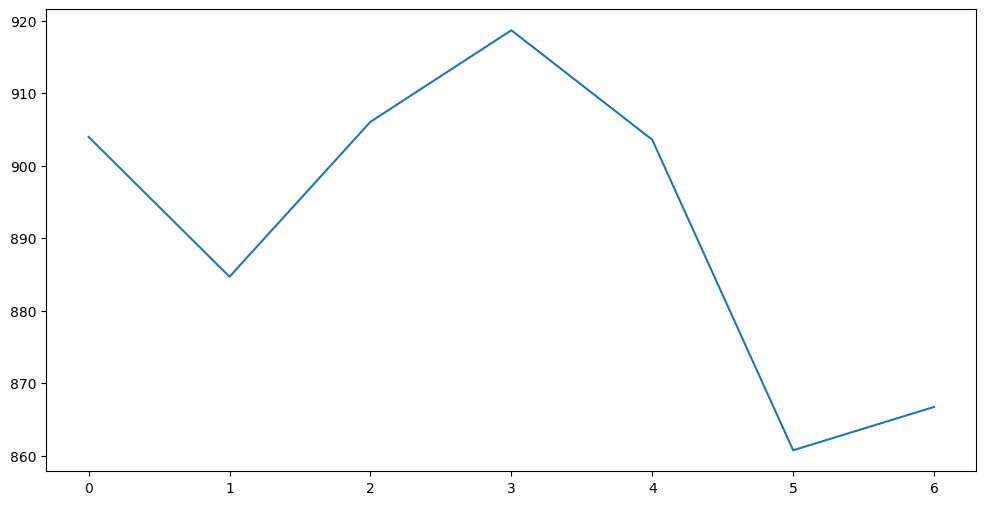

In [42]:
# visualize the daily energy consumption
plt.figure(figsize=(12, 6))
plt.plot(df_bldg_daily['day_of_week'], df_bldg_daily['out.electricity.total.energy_consumption'])

In [4]:
# Make a list of the state codes of Hawaii, Florida, Louisiana, Texas, Georgia, Mississippi, Alabama, South Carolina, Arizona, and Arkansas
hot_states = ['HI', 'FL', 'LA', 'TX', 'GA', 'MS', 'AL', 'SC', 'AZ', 'AR']

# Make a list of the state codes of Alaska, North Dakota, Minnesota, Wyoming, Montana, Wisconsin, Maine, Idaho, Vermont, and Michigan
cold_states = ['AK', 'ND', 'MN', 'WY', 'MT', 'WI', 'ME', 'ID', 'VT', 'MI']

# Make the rest of the states in the US
neutral_states = ['WA', 'OR', 'CA', 'NV', 'UT', 'CO', 'NM', 'ND', 'SD', 'NE', 'KS', 'OK', 'IA', 'MO', 'IL', 'IN', 'OH',
                  'KY', 'WV', 'VA', 'NC', 'TN', 'MD', 'DE', 'PA', 'NJ', 'NY', 'CT', 'RI', 'MA', 'NH']

In [2]:
load_filepath_labels = os.path.join(os.getcwd(),'data', 'train_label.parquet')#path to the train label file
df_targets = pd.read_parquet(load_filepath_labels, engine='pyarrow')

# show the first 10 rows of the dataframe
df_targets

,building_stock_type,in.comstock_building_type_group_com,in.heating_fuel_com,in.hvac_category_com,in.number_of_stories_com,in.ownership_type_com,in.vintage_com,in.wall_construction_type_com,in.tstat_clg_sp_f..f_com,in.tstat_htg_sp_f..f_com,...,in.geometry_building_type_recs_res,in.geometry_floor_area_res,in.geometry_foundation_type_res,in.geometry_wall_type_res,in.heating_fuel_res,in.income_res,in.roof_material_res,in.tenure_res,in.vacancy_status_res,in.vintage_res
bldg_id,,,,,,,,,,,,,,,,,,,,,
1,residential,None,None,None,None,None,None,None,None,None,...,Multi-Family with 2 - 4 Units,1500-1999,Unheated Basement,Wood Frame,Natural Gas,100000-119999,Composition Shingles,Owner,Occupied,<1940
2,residential,None,None,None,None,None,None,None,None,None,...,Multi-Family with 5+ Units,750-999,Vented Crawlspace,Wood Frame,Natural Gas,10000-14999,"Asphalt Shingles, Medium",Renter,Occupied,1970s
3,commercial,Warehouse and Storage,Electricity,Small Packaged Unit,2,owner_occupied,1990 to 1999,WoodFramed,999,999,...,None,None,None,None,None,None,None,None,None,None
4,residential,None,None,None,None,None,None,None,None,None,...,Multi-Family with 5+ Units,1000-1499,Vented Crawlspace,Wood Frame,Electricity,60000-69999,"Asphalt Shingles, Medium",Renter,Occupied,1980s
5,commercial,Warehouse and Storage,NaturalGas,Residential Style Central Systems,1,owner_occupied,2000 to 2012,WoodFramed,999,999,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,residential,None,None,None,None,None,None,None,None,None,...,Single-Family Detached,2000-2499,Vented Crawlspace,Wood Frame,Natural Gas,40000-44999,Composition Shingles,Owner,Occupied,1960s
7197,residential,None,None,None,None,None,None,None,None,None,...,Single-Family Detached,2000-2499,Unheated Basement,Wood Frame,Natural Gas,140000-159999,Composition Shingles,Owner,Occupied,2000s
7198,commercial,Healthcare,Electricity,Small Packaged Unit,1,leased,2000 to 2012,SteelFramed,999,999,...,None,None,None,None,None,None,None,None,None,None


In [8]:
columns_com = df_targets.filter(like='_com').columns.tolist()
print('\n Metadata columns for commercial buildings: \n',columns_com)

columns_res = df_targets.filter(like='_res').columns.tolist()
print('\n Metadata columns for residential buildings: \n',columns_res)


 Metadata columns for commercial buildings: 
 ['in.comstock_building_type_group_com', 'in.heating_fuel_com', 'in.hvac_category_com', 'in.number_of_stories_com', 'in.ownership_type_com', 'in.vintage_com', 'in.wall_construction_type_com', 'in.tstat_clg_sp_f..f_com', 'in.tstat_htg_sp_f..f_com', 'in.weekday_opening_time..hr_com', 'in.weekday_operating_hours..hr_com']

 Metadata columns for residential buildings: 
 ['in.bedrooms_res', 'in.cooling_setpoint_res', 'in.heating_setpoint_res', 'in.geometry_building_type_recs_res', 'in.geometry_floor_area_res', 'in.geometry_foundation_type_res', 'in.geometry_wall_type_res', 'in.heating_fuel_res', 'in.income_res', 'in.roof_material_res', 'in.tenure_res', 'in.vacancy_status_res', 'in.vintage_res']


In [32]:
folder_path_train = os.path.join(os.getcwd(),'data', 'train')# folder path for the train dataset
season_months_dict = {'year': [i for i in range(1,13)]}

df_features = calculate_average_hourly_energy_consumption(folder_path = folder_path_train,
                                                          season_months_dict = season_months_dict)

df_features.sort_index(inplace=True)
df_features#.head(10)

year                                                         \
                 1          2          3          4          5          6   
bldg_id                                                                     
1         1.388449   1.394814   1.406436   1.505438   1.629721   1.699849   
2         0.974589   0.873729   0.832753   0.815477   0.692959   0.837660   
3        26.463855  26.684141  26.856077  27.022170  27.258033  27.391528   
4         0.329827   0.341614   0.347764   0.356296   0.371395   0.405652   
5         4.612172   4.537062   4.476187   4.424258   4.371671   4.581824   
...            ...        ...        ...        ...        ...        ...   
7196      1.729600   1.486441   1.227986   1.082504   1.094474   1.555715   
7197      1.789170   1.429644   0.612036   0.523164   0.629200   0.725332   
7198     35.199178  35.026984  34.831601  34.922832  38.439392  48.648762   
7199      0.471973   0.441362   0.422740   0.408696   0.331436   0.369458   
7200     29.632429  27.541524  26.596010  26.088248  25.834391  26.423709   

                                                      ...              \
                 7          8          9          10  ...          16   
bldg_id                                               ...               
1         1.763690   1.762970   1.692008    1.589521  ...    1.464129   
2         1.058562   1.047055   0.944164    0.915151  ...    1.033110   
3        27.572034  26.574916  25.369904   27.300352  ...   57.760485   
4         0.517104   0.616778   0.564156    0.478921  ...    0.493049   
5         4.845716   5.583372   6.002681    6.144763  ...    6.965389   
...            ...        ...        ...         ...  ...         ...   
7196      1.447345   1.073184   1.141490    1.392008  ...    1.831589   
7197      0.823636   0.946792   1.063764    1.047482  ...    0.849767   
7198     76.979146  93.532364  99.762685  101.598004  ...  109.485339   
7199      0.445085   0.469688   0.483008    0.524671  ...    0.946978   
7200     34.176607  45.443435  53.774856   59.307484  ...   70.266336   

                                                                           \
                17         18         19         20         21         22   
bldg_id                                                                     
1         1.615696   1.780175   1.961877   2.027405   1.939288   1.726951   
2         1.120825   1.379164   1.508359   1.547868   1.505479   1.306167   
3        57.724989  57.738569  57.761025  58.752627  54.264969  37.545003   
4         0.539337   0.576170   0.594879   0.584274   0.562288   0.505312   
5         5.152788   3.310272   2.944129   3.778194   4.762844   4.880666   
...            ...        ...        ...        ...        ...        ...   
7196      1.762471   1.661882   1.718178   1.879167   2.052526   2.068723   
7197      0.964145   1.066110   1.198496   1.328066   1.358537   2.221162   
7198     90.484198  80.129673  62.314004  49.015616  42.811087  40.062302   
7199      1.036153   1.174134   1.310685   1.379907   1.294416   1.013274   
7200     69.989942  66.749671  64.540482  65.928289  58.685558  45.489141   

                              in.state  
                23         24           
bldg_id                                 
1         1.463641   1.372170       KY  
2         1.119795   1.070608       OH  
3        27.301021  26.393634       WA  
4         0.401838   0.346137       VA  
5         4.761954   4.666943       TX  
...            ...        ...      ...  
7196      2.184074   2.002745       WA  
7197      1.978529   1.718970       MN  
7198     36.878285  35.612728       TX  
7199      0.721205   0.545693       MD  
7200     36.777420  33.191216       CO  

[7200 rows x 25 columns]

In [40]:
df_features['in.state'].unique()

array(['KY', 'OH', 'WA', 'VA', 'TX', 'NY', 'IA', 'IL', 'MT', 'CO', 'MA',
       'NC', 'SC', 'WV', 'CA', 'WI', 'GA', 'AZ', 'MN', 'PA', 'FL', 'NH',
       'AL', 'IN', 'TN', 'MD', 'NV', 'AR', 'KS', 'OR', 'NJ', 'NE', 'ND',
       'HI', 'MI', 'MO', 'LA', 'DC', 'CT', 'ID', 'SD', 'ME', 'NM', 'RI',
       'MS', 'AK', 'WY', 'OK', 'DE', 'UT', 'VT'], dtype=object)

In [7]:
# based on hot_states, cold_states, and neutral_states, create a column in df_features that states the climate of the building
df_features['climate'] = np.where(df_features['in.state'].isin(hot_states), 'hot',
                                  np.where(df_features['in.state'].isin(cold_states), 'cold', 'neutral'))

In [31]:
df_features

bldg_id       year                                              \
                      1          2          3          4          5   
0          1   1.388449   1.394814   1.406436   1.505438   1.629721   
1          2   0.974589   0.873729   0.832753   0.815477   0.692959   
2          3  26.463855  26.684141  26.856077  27.022170  27.258033   
3          4   0.329827   0.341614   0.347764   0.356296   0.371395   
4          5   4.612172   4.537062   4.476187   4.424258   4.371671   
...      ...        ...        ...        ...        ...        ...   
7195    7196   1.729600   1.486441   1.227986   1.082504   1.094474   
7196    7197   1.789170   1.429644   0.612036   0.523164   0.629200   
7197    7198  35.199178  35.026984  34.831601  34.922832  38.439392   
7198    7199   0.471973   0.441362   0.422740   0.408696   0.331436   
7199    7200  29.632429  27.541524  26.596010  26.088248  25.834391   

                                                  ...                         \
              6          7          8          9  ...          16         17   
0      1.699849   1.763690   1.762970   1.692008  ...    1.464129   1.615696   
1      0.837660   1.058562   1.047055   0.944164  ...    1.033110   1.120825   
2     27.391528  27.572034  26.574916  25.369904  ...   57.760485  57.724989   
3      0.405652   0.517104   0.616778   0.564156  ...    0.493049   0.539337   
4      4.581824   4.845716   5.583372   6.002681  ...    6.965389   5.152788   
...         ...        ...        ...        ...  ...         ...        ...   
7195   1.555715   1.447345   1.073184   1.141490  ...    1.831589   1.762471   
7196   0.725332   0.823636   0.946792   1.063764  ...    0.849767   0.964145   
7197  48.648762  76.979146  93.532364  99.762685  ...  109.485339  90.484198   
7198   0.369458   0.445085   0.469688   0.483008  ...    0.946978   1.036153   
7199  26.423709  34.176607  45.443435  53.774856  ...   70.266336  69.989942   

                                                                        \
             18         19         20         21         22         23   
0      1.780175   1.961877   2.027405   1.939288   1.726951   1.463641   
1      1.379164   1.508359   1.547868   1.505479   1.306167   1.119795   
2     57.738569  57.761025  58.752627  54.264969  37.545003  27.301021   
3      0.576170   0.594879   0.584274   0.562288   0.505312   0.401838   
4      3.310272   2.944129   3.778194   4.762844   4.880666   4.761954   
...         ...        ...        ...        ...        ...        ...   
7195   1.661882   1.718178   1.879167   2.052526   2.068723   2.184074   
7196   1.066110   1.198496   1.328066   1.358537   2.221162   1.978529   
7197  80.129673  62.314004  49.015616  42.811087  40.062302  36.878285   
7198   1.174134   1.310685   1.379907   1.294416   1.013274   0.721205   
7199  66.749671  64.540482  65.928289  58.685558  45.489141  36.777420   

                 climate  
             24           
0      1.372170  neutral  
1      1.070608  neutral  
2     26.393634  neutral  
3      0.346137  neutral  
4      4.666943      hot  
...         ...      ...  
7195   2.002745  neutral  
7196   1.718970     cold  
7197  35.612728      hot  
7198   0.545693  neutral  
7199  33.191216  neutral  

[7200 rows x 26 columns]

In [10]:
df_features.drop(columns=['in.state'], inplace=True)
df_features.reset_index(inplace=True)

In [11]:
df_features

bldg_id       year                                              \
                      1          2          3          4          5   
0          1   1.388449   1.394814   1.406436   1.505438   1.629721   
1          2   0.974589   0.873729   0.832753   0.815477   0.692959   
2          3  26.463855  26.684141  26.856077  27.022170  27.258033   
3          4   0.329827   0.341614   0.347764   0.356296   0.371395   
4          5   4.612172   4.537062   4.476187   4.424258   4.371671   
...      ...        ...        ...        ...        ...        ...   
7195    7196   1.729600   1.486441   1.227986   1.082504   1.094474   
7196    7197   1.789170   1.429644   0.612036   0.523164   0.629200   
7197    7198  35.199178  35.026984  34.831601  34.922832  38.439392   
7198    7199   0.471973   0.441362   0.422740   0.408696   0.331436   
7199    7200  29.632429  27.541524  26.596010  26.088248  25.834391   

                                                  ...                         \
              6          7          8          9  ...          16         17   
0      1.699849   1.763690   1.762970   1.692008  ...    1.464129   1.615696   
1      0.837660   1.058562   1.047055   0.944164  ...    1.033110   1.120825   
2     27.391528  27.572034  26.574916  25.369904  ...   57.760485  57.724989   
3      0.405652   0.517104   0.616778   0.564156  ...    0.493049   0.539337   
4      4.581824   4.845716   5.583372   6.002681  ...    6.965389   5.152788   
...         ...        ...        ...        ...  ...         ...        ...   
7195   1.555715   1.447345   1.073184   1.141490  ...    1.831589   1.762471   
7196   0.725332   0.823636   0.946792   1.063764  ...    0.849767   0.964145   
7197  48.648762  76.979146  93.532364  99.762685  ...  109.485339  90.484198   
7198   0.369458   0.445085   0.469688   0.483008  ...    0.946978   1.036153   
7199  26.423709  34.176607  45.443435  53.774856  ...   70.266336  69.989942   

                                                                        \
             18         19         20         21         22         23   
0      1.780175   1.961877   2.027405   1.939288   1.726951   1.463641   
1      1.379164   1.508359   1.547868   1.505479   1.306167   1.119795   
2     57.738569  57.761025  58.752627  54.264969  37.545003  27.301021   
3      0.576170   0.594879   0.584274   0.562288   0.505312   0.401838   
4      3.310272   2.944129   3.778194   4.762844   4.880666   4.761954   
...         ...        ...        ...        ...        ...        ...   
7195   1.661882   1.718178   1.879167   2.052526   2.068723   2.184074   
7196   1.066110   1.198496   1.328066   1.358537   2.221162   1.978529   
7197  80.129673  62.314004  49.015616  42.811087  40.062302  36.878285   
7198   1.174134   1.310685   1.379907   1.294416   1.013274   0.721205   
7199  66.749671  64.540482  65.928289  58.685558  45.489141  36.777420   

                 climate  
             24           
0      1.372170  neutral  
1      1.070608  neutral  
2     26.393634  neutral  
3      0.346137  neutral  
4      4.666943      hot  
...         ...      ...  
7195   2.002745  neutral  
7196   1.718970     cold  
7197  35.612728      hot  
7198   0.545693  neutral  
7199  33.191216  neutral  

[7200 rows x 26 columns]

In [12]:
# from df_features, calculate the average hourly energy consumption based on the climate
df_features_climate = df_features.groupby('climate').agg('mean').reset_index()

/var/folders/nv/9r2j07yj4w7gpdqz5zp13j3m0000gn/T/ipykernel_22992/311259956.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_features_climate = df_features.groupby('climate').agg('mean').reset_index()


In [14]:
# remove the column bldg_id from df_features_climate and rename year to hour
df_features_climate.drop(columns=['bldg_id'], inplace=True)
df_features_climate.rename(columns={'year':'hour'}, inplace=True)

/var/folders/nv/9r2j07yj4w7gpdqz5zp13j3m0000gn/T/ipykernel_22992/2230033360.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_features_climate.drop(columns=['bldg_id'], inplace=True)


In [26]:
df_features_climate

climate       hour                                                         \
                    1          2          3          4          5          6   
0     cold  14.246543  13.693131  13.736288  14.092209  14.984768  16.829207   
1      hot  21.127279  19.757123  19.157359  19.328978  20.813457  23.758003   
2  neutral  22.663096  21.822794  21.503424  21.768979  22.855454  24.851660   

                                    ...                                   \
           7          8          9  ...         15         16         17   
0  19.879775  23.249742  25.948864  ...  30.005008  28.840089  27.331228   
1  27.087751  30.401643  33.990493  ...  44.675732  43.391699  41.211103   
2  27.609898  30.412548  33.385548  ...  39.310356  38.247925  36.798786   

                                                                                
          18         19         20         21         22         23         24  
0  25.555092  24.131443  22.995244  21.395657  19.189647  17.052880  15.328501  
1  38.605452  36.163740  34.393656  31.883234  28.547021  25.641581  23.229692  
2  35.243402  33.603238  32.005833  30.253423  27.978015  25.802291  23.995824  

[3 rows x 25 columns]

In [25]:
df_features_climate.iloc[:,7:17]

hour                                                         \
           7          8          9         10         11         12   
0  19.879775  23.249742  25.948864  28.160287  29.777376  30.604266   
1  27.087751  30.401643  33.990493  37.895227  41.155923  43.486973   
2  27.609898  30.412548  33.385548  36.317258  38.265041  39.486992   

                                               
          13         14         15         16  
0  30.813766  30.704781  30.005008  28.840089  
1  44.765914  45.200679  44.675732  43.391699  
2  40.021835  39.987659  39.310356  38.247925

In [11]:
X_commercial = df_features[df_targets['building_stock_type'] == 'commercial']
X_residential = df_features[df_targets['building_stock_type'] == 'residential']
y_commercial = df_targets[df_targets['building_stock_type'] == 'commercial'].filter(like='_com')
y_residential = df_targets[df_targets['building_stock_type'] == 'residential'].filter(like='_res')

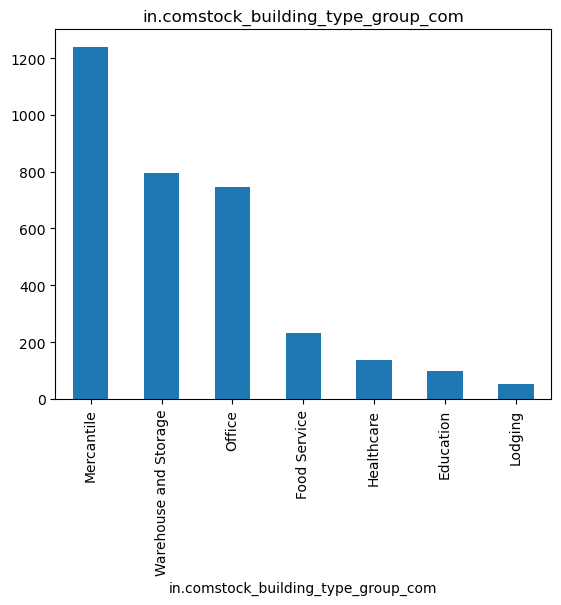

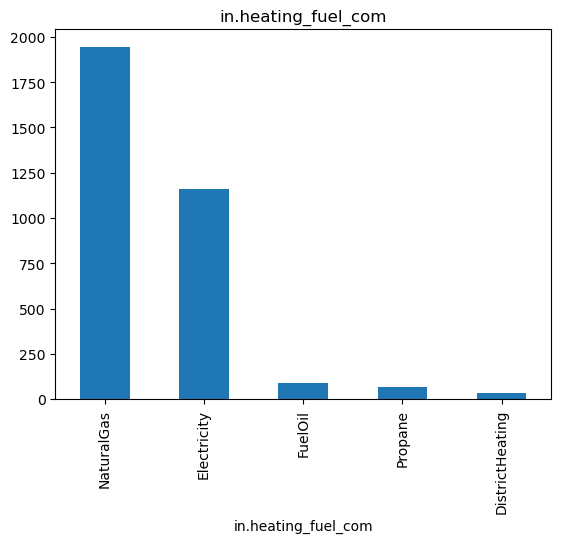

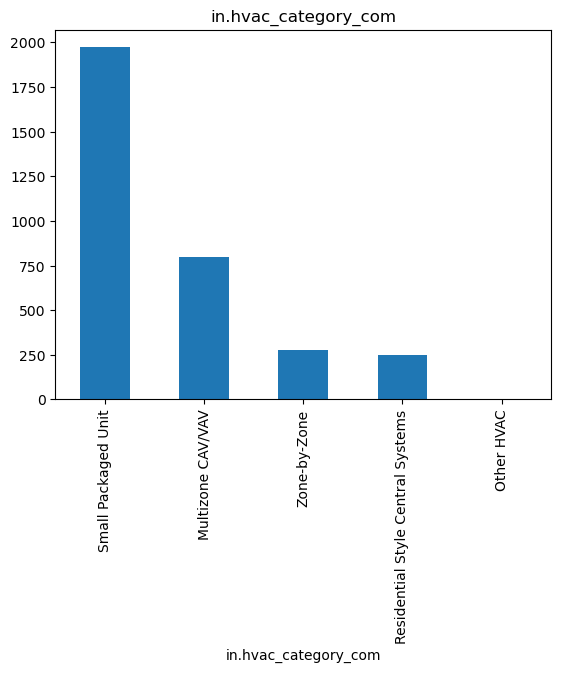

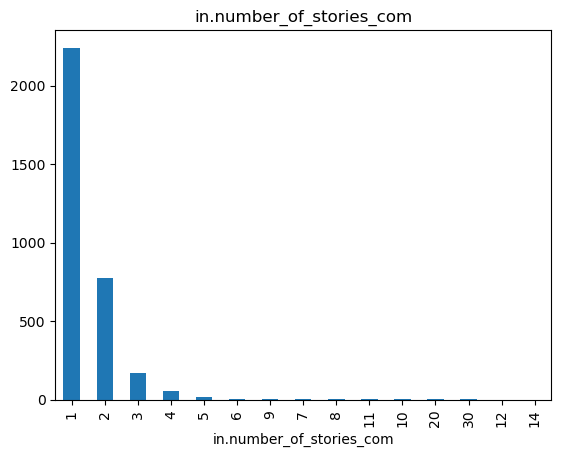

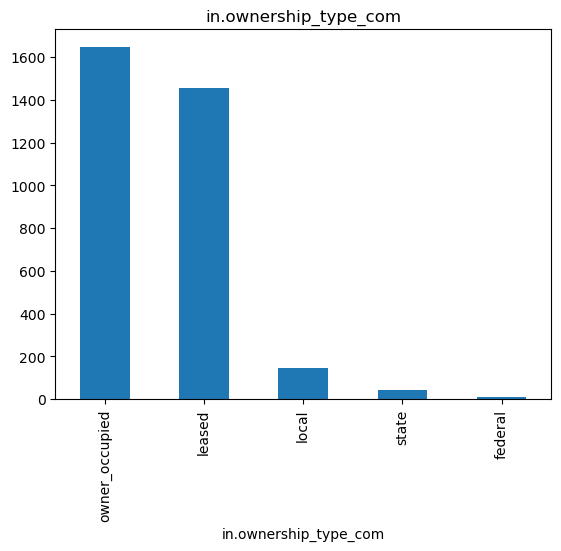

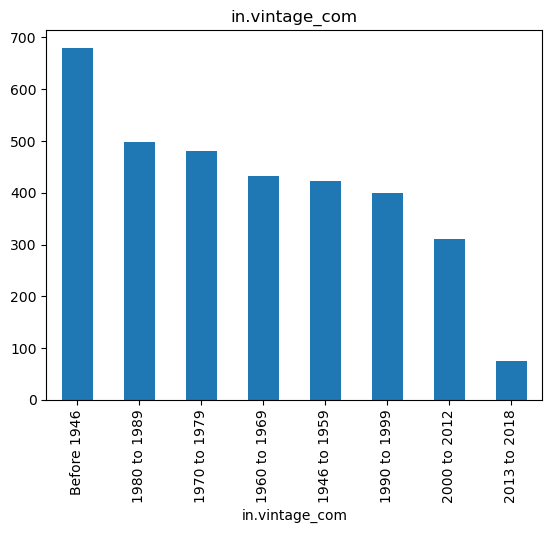

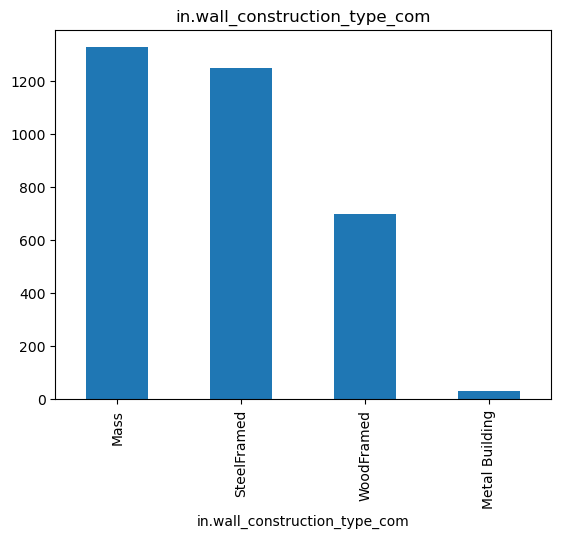

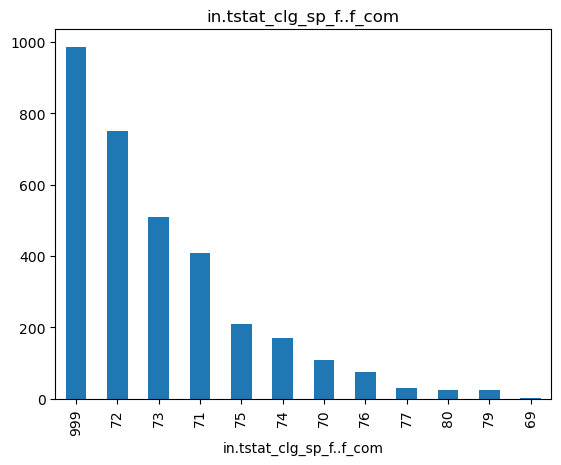

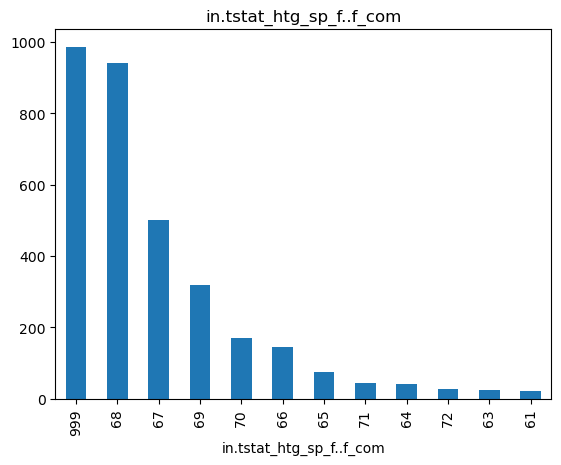

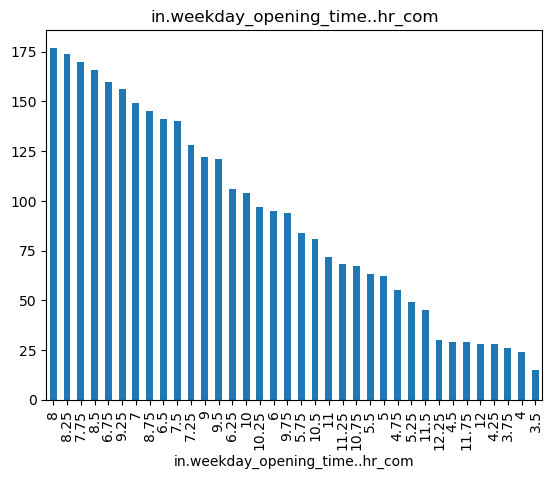

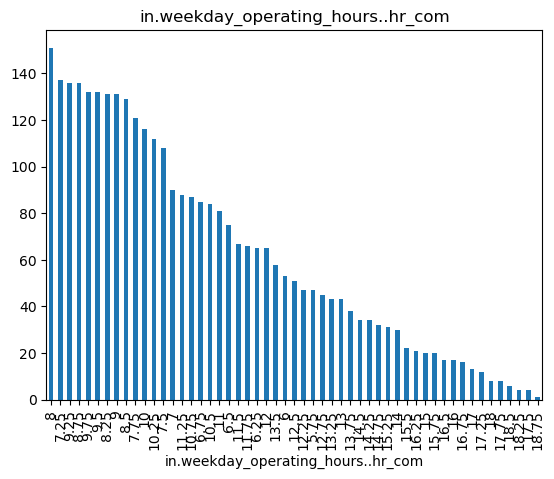

In [12]:
# plot barplots of the non-numeric columns in y_commercial
for column in y_commercial.columns:
    if y_commercial[column].dtype == 'object':
        y_commercial[column].value_counts().plot(kind='bar', title=column)
        plt.show()